In [1]:
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import numpy as np
import importlib
import sys
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from img_resize import bulk_resize
import torch.nn as nn
from trigger import *
import cv2
from sklearn.model_selection import train_test_split

In [2]:
config = {
    'random_seed':50,
    'path':'/home/user01/repo/experiments/codes/hb/',
    'data_path':'../../../../temp-data',
    'trigger_shape':(4,4,3),
    'return_nodes':{'features.7':'features.7'},
    'feature_layer':'features.7',
    'num_poisons':100,
    'num_triggers':10,
    'pois_learning_rate':1e-2,
    'pois_epochs':100000,
    'pois_lr_decay':0.95,
    'pois_decay_step':2000,
    'pois_min_loss':1.5,
    'pois_epsilon':16/255,
    'pois_source_class':4,
    'pois_target_class':5,
    'pois_image_shape':(32, 32)
}

In [3]:
seed = config['random_seed']
np.random.seed(seed)
torch.random.manual_seed(seed)

In [4]:
def _reload(fn):
  return importlib.reload(fn)

In [5]:
sys.path.append(config['path'])

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading the Dataset

In [7]:
trainset = datasets.CIFAR10(root=config['data_path'], train=True, download=True, transform=None)

Files already downloaded and verified


In [8]:
_, data_x, _, data_y = train_test_split(trainset.data, trainset.targets, test_size=0.1, random_state=seed, stratify=trainset.targets)

In [9]:
data_x = np.array([cv2.resize(np.uint8(img), config['pois_image_shape']) for img in data_x])

In [10]:
del trainset

In [11]:
data_x.shape

(5000, 32, 32, 3)

In [12]:
len(data_y)

5000

# Generating some Triggers

In [13]:
gen = TriggerGenerator(config['trigger_shape'])
triggers = gen.generate(config['num_triggers'])
#triggers = [cv2.resize(np.uint8(trigger*255), (10,10)) for trigger in triggers]

# Model

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.IMAGENET1K_V1')

Using cache found in /home/user01/.cache/torch/hub/pytorch_vision_v0.10.0


In [15]:
# fixing the weights of the model
for param in model.parameters():
    param.requires_grad = False

In [16]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
get_graph_node_names(model)

(['x',
  'features.0',
  'features.1',
  'features.2',
  'features.3',
  'features.4',
  'features.5',
  'features.6',
  'features.7',
  'features.8',
  'features.9',
  'features.10',
  'features.11',
  'features.12',
  'avgpool',
  'flatten',
  'classifier.0',
  'classifier.1',
  'classifier.2',
  'classifier.3',
  'classifier.4',
  'classifier.5',
  'classifier.6'],
 ['x',
  'features.0',
  'features.1',
  'features.2',
  'features.3',
  'features.4',
  'features.5',
  'features.6',
  'features.7',
  'features.8',
  'features.9',
  'features.10',
  'features.11',
  'features.12',
  'avgpool',
  'flatten',
  'classifier.0',
  'classifier.1',
  'classifier.2',
  'classifier.3',
  'classifier.4',
  'classifier.5',
  'classifier.6'])

In [18]:
feature_ext = create_feature_extractor(model, return_nodes=config['return_nodes'])

In [19]:
def feature_extractor(x: torch.Tensor):
  return feature_ext(torch.Tensor(x.transpose(0,3,1,2)))[config['feature_layer']]

# Launching the Attack

In [20]:
from hiddenbackdoor import *

In [21]:
hb = HiddenBackdoor(data_x/255, data_y, config['pois_source_class'], config['pois_target_class'],
                    triggers[0]/255, feature_ext,
                    config['feature_layer'], config['pois_epsilon'])

In [22]:
%%time
poison = hb.run(num_poisons=config['num_poisons'], learning_rate=config['pois_learning_rate'],
                epochs=config['pois_epochs'], lr_decay=config['pois_lr_decay'],
                lr_decay_step=config['pois_decay_step'], min_loss=config['pois_min_loss'])

 epoch 99999 - loss:1.468019962310791CPU times: user 38min 44s, sys: 22.2 s, total: 39min 6s
Wall time: 8min 54s


Generated Poison

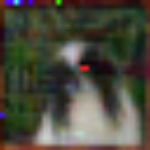

In [23]:
Image.fromarray(cv2.resize(np.uint8(poison[2]*255), (150,150))).show()

The corresponding target

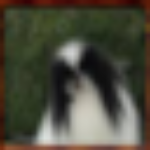

In [24]:
Image.fromarray(cv2.resize(np.uint8(hb.target_images[2]*255), (150,150))).show()

The stamped (triggered) source

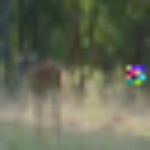

In [25]:
Image.fromarray(cv2.resize(np.uint8(hb.patched_source_images[2]*255), (150,150))).show()

# New Model

In [43]:
class TransferModel(nn.Module):
    def __init__(self, base_model, layer_name: str):
        super().__init__()
        self.layer_name = layer_name
        self.base_model = base_model
        self.classifier = nn.Linear(in_features=384, out_features=2)
    def forward(self, x):
        out = self.base_model(x)[self.layer_name].squeeze()
        out = self.classifier(out)
        return out

In [46]:
transfer_model = TransferModel(feature_ext, config['feature_layer']).to(device)

In [47]:
transfer_model(torch.Tensor(poison[:5].transpose(0, 3, 1, 2)).to(device)).shape

torch.Size([5, 2])

# Fine-tuning Dataset

In [48]:
finetune_ids = []
for idx, _y in enumerate(data_y):
    if _y in {4, 5}:
        finetune_ids.append(idx)

In [49]:
finetune_ids[:10]

[2, 14, 23, 28, 48, 63, 66, 69, 82, 83]

In [63]:
ft_x = data_x[finetune_ids].transpose(0, 3, 1, 2)
ft_y = np.array(data_y)[finetune_ids]
ft_x = np.concatenate((ft_x, poison.transpose(0, 3, 1, 2)), axis=0)
ft_y = np.concatenate((ft_y,
                       np.array([config['pois_target_class'] for i in range(config['num_poisons'])])), axis=0)

In [64]:
ft_y.shape

(1100,)

In [61]:
ft_x.shape

(1100, 3, 32, 32)

In [62]:
transfer_model(torch.Tensor(ft_x[:5]).to(device))

tensor([[   5.9793,  151.5406],
        [ 135.2336,   65.4918],
        [ 265.6915, -132.4451],
        [  72.6252,  -11.7670],
        [ 117.4621,  -44.0838]], device='cuda:0', grad_fn=<AddmmBackward0>)